In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report
import torch
import matplotlib.pyplot as plt

import os

In [2]:
#In this cell, the datasets are downloaded via the KaggleAPI directly from the source. It might be necessary to authentificate first via Webbrowser to make this work.
#FUrthermore, a folder ../data is created, which is on the .gitignore list. In this folder, large files >100mb and the original datasets MITBIH and PTBDB are stored.

from kaggle.api.kaggle_api_extended import KaggleApi

#configuring and authentification with kaggle api. This could be configured so that a authentification mask is shown?
api = KaggleApi()
api.authenticate()

#Configuring the metadata for the ecg heartbeat data (original username etc)
dataset_owner = "shayanfazeli"
dataset_name = "heartbeat"

#Configuring a download path that is NOT in the current github repo (so the big files are not pushed and cause an error!) --> Links to filepaths have to be dynamically adjusted
download_path = "../data/KAGGLE_datasets" #In this case we use the data folder that is in the .gitignore list and therefore not pushed! To keep everything in one local repo.

# Download structure: First check if dataset is already downloaded, else download it and store it in download path (should be outside git repo!)
dataset_folder = os.path.join(download_path, dataset_name)
if not os.path.exists(dataset_folder):
    # Case 1: Dataset path is not created --> Create it and download datasets into it
    api.dataset_download_files(dataset_owner + "/" + dataset_name, path=download_path + "/" + dataset_name, unzip=True)
    print("Datasets are downloaded and unzipped.")
else:
    # Case 2: Folder is created, but datasets might be missing
    missing_files = [] 
    for file_name in ["mitbih_test.csv", "mitbih_train.csv", "ptbdb_abnormal.csv", "ptbdb_normal.csv"]:  # These are the hardcoded names of the datasets that should be downloaded.
        file_path = os.path.join(dataset_folder, file_name)
        if not os.path.exists(file_path):
            missing_files.append(file_name)

    if missing_files:
        # If the list contains missing files, download ALL files and overwrite the old folder.
        api.dataset_download_files(dataset_owner + "/" + dataset_name, path=download_path + "/" + dataset_name, unzip=True, force=True)
        print("Missing data was donwloaded and unzipped. All Datasets are now available.")
    else:
        print("All Datasets are already available.")

#Creating new variable that links to the datasets and can be used in the rest of the code.
path_to_datasets = download_path + "/" + dataset_name 

All Datasets are already available.


In [3]:
np.set_printoptions(precision=4)

In [4]:
# This cell now makes use of the downloadfolder for the datasets. If already available locally, the filepaths can be changed.
df_train= pd.read_csv(path_to_datasets + "/" + 'mitbih_train.csv', header=None)
df_test=pd.read_csv(path_to_datasets + "/" +  'mitbih_test.csv',header=None)
print("Dataframes MITBIH correctly read into workspace")

df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

#split target and value
train_target=df_train[187]
test_target=df_test[187]
train=df_train.drop(187,axis=1)
test=df_test.drop(187,axis=1)

Dataframes MITBIH correctly read into workspace


In [5]:
#Switches to decide the dataset sampling method and which models should be run
class Config_Sampling:
    oversample = False #equals to B_SMOTE
    undersample = False
    sample_name = "UNDEFINED_SAMPLE"
    
Train_Simple_ANN = True #Trains the simple ANN
Train_Simple_CNN = True #Trains the simple CNN
Train_Advanced_CNN = True #Trains the advanced CNN
 

In [6]:
oversampler = SMOTE()
undersampler = RandomUnderSampler()

In [7]:
#Based on the configuration in the Config_Sampling Class, the datasets are sampled and the sample name is modified accordingly
if Config_Sampling.oversample:
    train, train_target = oversampler.fit_resample(df_train.iloc[:,:-1], df_train.iloc[:,-1])
    Config_Sampling.sample_name = "MITBIH_B_SMOTE"
    print("Sample Name:", Config_Sampling.sample_name)
elif Config_Sampling.undersample:
    train, train_target = undersampler.fit_resample(df_train.iloc[:,:-1], df_train.iloc[:,-1])
    Config_Sampling.sample_name = "MITBIH_C_RUS"
    print("Sample Name:", Config_Sampling.sample_name)
else: 
    print("Using the original mitbih dataset")
    Config_Sampling.sample_name = "MITBIH_A_Original"
    print("Sample Name:", Config_Sampling.sample_name)

Using the original mitbih dataset
Sample Name: MITBIH_A_Original


## **Simple Artificial Neural Network**
ANN without convolutional layers. Only Dense layers are used. No Pooling, Flattening or Dropping out. Base model for later comparison.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

Implement Torch Dataset object

In [9]:
class ECG_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, target_transform=None):
        self.dataframe = csv_file.values
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataframe)
        #return self.dataframe.shape[0] # Alternative notation

    def __getitem__(self, idx):
        inputs = torch.tensor(self.dataframe[idx,:-1]).to(torch.float32)
        label = torch.tensor(self.dataframe[idx,-1]).long()

        return inputs, label

In [10]:
training_data = ECG_Dataset(df_train)
test_data = ECG_Dataset(df_test)

In [11]:
len(test_data)

21892

Torch Dataloader

In [12]:
from torch.utils.data import DataLoader

trainloader = DataLoader(training_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data, batch_size=64)

In [13]:
# Define the ANN model
class SimpleANN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 212)  # Input to hidden layer
        self.fc2 = nn.Linear(212, 150)  # Input to hidden layer
        self.fc3 = nn.Linear(150, 60)  # Hidden to output layer
        self.fc4 = nn.Linear(60, 24)  # Hidden to output layer
        self.fc5 = nn.Linear(24, 12)  # Hidden to output layer
        self.fc6 = nn.Linear(12, output_size)  # Hidden to output layer
        self.relu = nn.LeakyReLU(negative_slope=0.001)    # Activation function
        self.dropout = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        return x

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [15]:
# Define the model
input_size = 187  # Number of input features
output_size = 5  # Output size (e.g., regression or binary classification)
model = SimpleANN(input_size, output_size)

# Define loss and optimizer
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [20]:
def batch_loss_train(outputs, labels, loss_fn, optimizer):
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

In [26]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test set => Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
len(trainloader.dataset)

87554

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0.0
    
    for inputs, labels in dataloader:
        
        # forward + backward + optimize
        outputs = model(inputs)
        train_loss += batch_loss_train(outputs,labels,loss_fn, optimizer) / len(inputs)

    print(f'Epoch {epoch}: Train loss: {train_loss}')
    

In [28]:
epochs = 2
for epoch in range(epochs):  
    train_loop(trainloader, model, criterion, optimizer)
    test_loop(testloader, model, criterion)

print("Done!")

Epoch 0: Train loss: 4.471324415993877
Test set => Accuracy: 95.3%, Avg loss: 0.186515 

Epoch 1: Train loss: 4.1121639001357835
Test set => Accuracy: 95.5%, Avg loss: 0.176237 

Done!


## **Advanced CNN**

The model structure is enhanced by using MaxPooling and Dropout layers and an additional Conv1D layer, in comparison to the Simple CNN model above.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 185, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 92, 32)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 90, 16)            1552      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 44, 16)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 704)               0         
                                                                 
 dropout (Dropout)           (None, 704)              

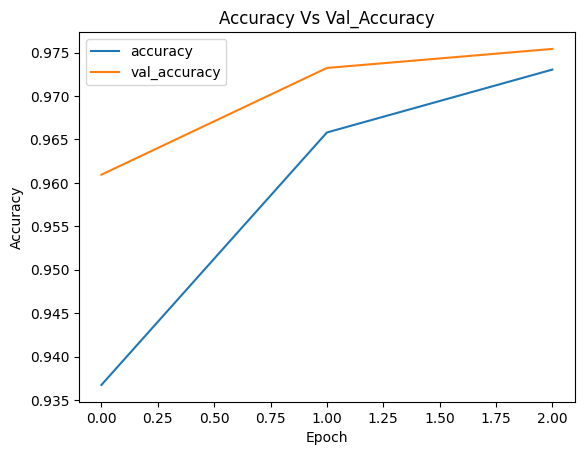

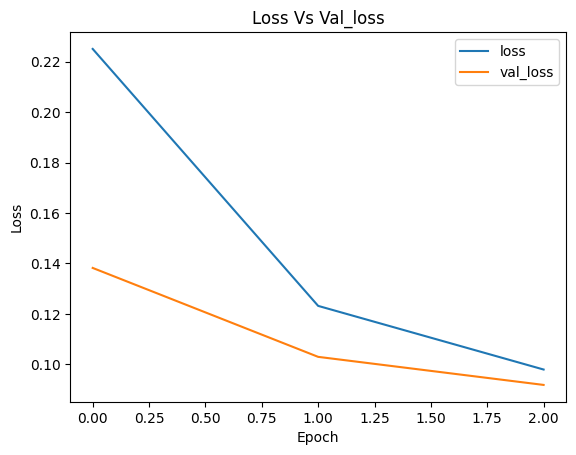

685/685 [==============================] - 4s 5ms/step
              precision    recall  f1-score   support

         0.0     0.9795    0.9944    0.9869     18118
         1.0     0.9239    0.6115    0.7359       556
         2.0     0.9504    0.9123    0.9309      1448
         3.0     0.8860    0.6235    0.7319       162
         4.0     0.9686    0.9795    0.9740      1608

    accuracy                         0.9754     21892
   macro avg     0.9417    0.8242    0.8719     21892
weighted avg     0.9747    0.9754    0.9740     21892

EVERYTHING FINISHED FOR ADVANCED CNN MODEL!


: 

In [37]:
if Train_Advanced_CNN == True:
    class Config_Advanced_CNN:
        epochs = 3 #70 is default (exp1)
        batch_size = 10 #10 is default (exp1)
        exp_name = 42 #Experiment Number counter 
        patience = 70 #10 # is default (exp1)
        initial_learning_rate=0.001 #Default Initial Learning Rate for ADAM: 0.001
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        reduce_lr_every_10_epochs = True #Reduce the learning rate each 10 Epochs with the rate defined below. Default is False for exp1.
        lr_reduction_rate = 0.5 # Reduction Rate for reducing each 10 epochs. 0.5 means, that lr is halfed each 10 epochs.
        Conv1_filter_num = 32 # Number of filters in the convolutional layer (more means more shape-variations can be detected) 
        Conv1_filter_size = 3 # Size (e.g. 3 by 3) of single convolutional kernel. More means a more rough approach to detection of patterns.
        filepath_checkpoint = '../models/DL_Models/Advanced_CNN/experiment_'+str(exp_name) + '_'+str (Config_Sampling.sample_name) +'.weights.h5'
        filepath_accuracy_plot = '../reports/figures/DL_Models/Advanced_CNN/experiment_'+str(exp_name) +  '_'+ str (Config_Sampling.sample_name) +'.accuracy_plot.png'
        filepath_loss_plot = '../reports/figures/DL_Models/Advanced_CNN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.loss_plot.png'
        filepath_classification_report = '../reports/figures/DL_Models/Advanced_CNN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.classification_report.txt'

    #Model structure: This is not changed during experiments.
    adv_cnn_model = tf.keras.models.Sequential()
    adv_cnn_model.add(tf.keras.layers.Conv1D(Config_Advanced_CNN.Conv1_filter_num, Config_Advanced_CNN.Conv1_filter_size, activation='relu', input_shape=(187, 1))) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.Conv1D(Config_Advanced_CNN.Conv1_filter_num//2, Config_Advanced_CNN.Conv1_filter_size, activation='relu' )) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.Flatten()) # After  
    adv_cnn_model.add(tf.keras.layers.Dropout(rate=0.2))
    adv_cnn_model.add(tf.keras.layers.Dense(120, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    adv_cnn_model.add(tf.keras.layers.Dense(60, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    adv_cnn_model.add(tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    adv_cnn_model.add(tf.keras.layers.Dense(5, activation='softmax'))
    
    #Function for the learning rate scheduler
    def lr_scheduler(epoch, lr):
        if Config_Advanced_CNN.reduce_lr_every_10_epochs and epoch % 10 == 0: # %10 == 0 means each 10 epochs (only then no "rest" after dividing trough 10)
            return lr * Config_Advanced_CNN.lr_reduction_rate  # reduce the learning rate with the configured rate
        else:
            return lr

    # callback for the learning rate reduction schedule (function)
    lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    
    #Model checkpoint: Saves the best model for all epochs with regards to the validation accuracy. Only weights (.h5) are saved.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=Config_Advanced_CNN.filepath_checkpoint,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    #Early stop callback: If validation accuracy does not change during the last XXX epochs, training is stopped (XXX is configured as patience)
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=Config_Advanced_CNN.patience)

    #Compilation of model with ADAM and custom lr, sparse_categorical_crossentropy since we have integers as class labels.
    adv_cnn_model.compile(optimizer=Config_Advanced_CNN.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    adv_cnn_model.summary()

    
    """The following transformation of DataFrames to NumPy arrays and reshaping them is necessary to match the input requirements of the Convolutional Neural Network model.
     CNNs in TensorFlow typically expect input data in the form of NumPy arrays with specific shapes, especially when using Conv1D layers.
    This reshaping ensures that the data is in the correct format for training and inference."""
    train_array = train.to_numpy()
    test_array = test.to_numpy()
    train_reshaped = train_array.reshape(train_array.shape[0], train_array.shape[1], 1)
    test_reshaped = test_array.reshape(test_array.shape[0], test_array.shape[1], 1)
    
    #training the model and storing all results in training history. aside from the datasets, all arguments are called from our config-class. Also calling the respective callbacks.
    adv_cnn_model_history = adv_cnn_model.fit(train_reshaped, train_target, epochs=Config_Advanced_CNN.epochs, batch_size=Config_Advanced_CNN.batch_size, 
                                      validation_data=(test_reshaped, test_target), 
                                      callbacks=[model_checkpoint_callback, early_stop_callback, lr_scheduler_callback])
    
    #some plots for early interpretion during the run
    plt.plot(adv_cnn_model_history.history['accuracy'])
    plt.plot(adv_cnn_model_history.history['val_accuracy'])
    plt.legend(["accuracy","val_accuracy"])
    plt.title(f'Accuracy Vs Val_Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(Config_Advanced_CNN.filepath_accuracy_plot)
    plt.show()
    plt.close()

    plt.plot(adv_cnn_model_history.history['loss'])
    plt.plot(adv_cnn_model_history.history['val_loss'])
    plt.legend(["loss","val_loss"])
    plt.title('Loss Vs Val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(Config_Advanced_CNN.filepath_loss_plot)
    plt.show()
    plt.close()

    #Predict on test set.
    predictions = adv_cnn_model.predict(test_reshaped).argmax(axis=1)
      
    #make classification report and save it directly as a file.
    report = classification_report(test_target, predictions, digits=4)
    print(report)
    with open(Config_Advanced_CNN.filepath_classification_report, 'w') as report_file:
        report_file.write(report)

    print("EVERYTHING FINISHED FOR ADVANCED CNN MODEL!")

else:
    print("ADVANCED CNN Model is not trained and evaluated")